In [12]:
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Outcar, Eigenval
from pymatgen.electronic_structure.core import Spin
import numpy as np

import pandas as pd

from os.path import expanduser
home = expanduser('~')

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


def format_ladder(orbitals, occu_matrix, spin=None):
    ladder = np.array(sorted(zip(np.diag(occu_matrix), orbitals), reverse=True))
    occu_ladder = ladder[:,0]
    orb_ladder = ladder[:,1]
    if spin == 1:
        row1 = '/\ Orbital:   '
        row2 = '/\ Occupation:'
    elif spin == -1:
        row1 = '\/ Orbital:   '
        row2 = '\/ Occupation:'
    for i in range(len(occu_ladder)):
        row1 = row1 + f'\t{orb_ladder[i]}'
        row2 = row2 + f'\t{occu_ladder[i]}'
    return row1 + '\n' + row2


def display_occu(odm, orbitals, order=None, print_ladder=True):
    up = odm[Spin.up]
    down = odm[Spin.down]
    
    ### Write header
    header = '\t'
    if order == None: order = range(5)
    for i in order:
        header = f'{header}{orbitals[i]}\t\t'
    print(header, end='')
    
    ### Write each row
    for i in order:
        print(f'\n{orbitals[i]}', end='\t')
        for j in order:
            entries = [np.round(up[i][j], 2), np.round(down[i][j], 2)]
            for k in range(2):
                if entries[k] == 0:
                    entries[k] = '----'
            print(f'{entries[0]} / {entries[1]}', end='\t')
    print('\n')
    if print_ladder:
        print(format_ladder(orbitals, up, spin=1))
        print()
        print(format_ladder(orbitals, down, spin=-1))
#         up_ladder = zip(np.diag(up), orbitals)
#         up_ladder =  sorted(up_ladder, reverse=True)
#         print(np.array(up_ladder).T)
#         print('\n')
        
#         dn_ladder = zip(np.diag(down), orbitals)
#         dn_ladder =  sorted(dn_ladder, reverse=True)
#         print(np.array(dn_ladder).T)
#         print('\n')
    

def print_occupations(iters, orbitals, n_with_U, order=None, atom_idx=0):
    odms = []
    for i, iter_1 in enumerate(iters):
            label = f'{iter_1}'
            outcar = Outcar(f'{PREFIX}-{label}{SUFFIX}')
            outcar.read_onsite_density_matrices()
            odm = outcar.data['onsite_density_matrices'][-n_with_U:] # we only want to odm from last iter
            odms.append(odm)
            print(f'##### {iter_1} #####')
            display_occu(odm[atom_idx], orbitals, order=order)
            print()

            
def parse_diag_occus(iters, orbitals, n_with_U, order=None, atom_idx=0, spin=-1):
    odms = []
    diag_occus = []
    for i, iter_1 in enumerate(iters):
        label = f'{iter_1}'
        ### jank fix for spin swapped run
        if label == 'exp_P4nmm_e249.5':
            print('activated')
            tmp_atom_idx = 6
        else:
            tmp_atom_idx = atom_idx
        ####################################
        outcar = Outcar(f'{PREFIX}/OUTCAR-{label}{SUFFIX}')
        outcar.read_onsite_density_matrices()
        odm = outcar.data['onsite_density_matrices'][-n_with_U:] # we only want to odm from last iter
        odms.append(odm)
        
        # Diagonalized
        if spin == -1:
            occu_matrix = odm[tmp_atom_idx][Spin.down]
        elif spin == 1:
            occu_matrix = odm[tmp_atom_idx][Spin.up]
        else:
            print("Invalid spin, should be +/- 1")
            return
        diag_occu = np.diag(occu_matrix)
        diag_occu = [diag_occu[i] for i in order]
        diag_occus.append(diag_occu)
    ordered_orbitals = [orbitals[i] for i in order] 
    df = pd.DataFrame(diag_occus, columns=ordered_orbitals)
    df.insert(0, 'x', ITERS_2)
    return df


def plot_diag_occus(label, df, legend_labels, norm=None):
    fig = plt.figure(figsize=(7,3))
    x = df['x']
    if norm:
        for i in range(len(df)):
            df.iloc[i] = pd.concat([df.iloc[i][:1], df.iloc[i][1:]/sum(df.iloc[i][1:])*norm])    
    for i in range(len(legend_labels)):
        if legend_labels[i] in ['$d_{yz}$']:
            plt.plot(x, df[df.columns[i+1]], 'x--', label=legend_labels[i])
        elif legend_labels[i] in ['$d_{xz}$']:
            plt.plot(x, df[df.columns[i+1]], '+--', label=legend_labels[i])
        else:
            plt.plot(x, df[df.columns[i+1]], 'o-', label=legend_labels[i])
#     plt.xlabel('Electron Count')
    plt.xlabel('$U_{eff}$ (eV)')
    if norm: plt.ylabel('Normalized Occupancy')
    else:    plt.ylabel('Orbital Occupancy')
    plt.grid(1)
    plt.ylim(0,1.05)
#     plt.legend(bbox_to_anchor=(1, 1.3), ncol=5)
    plt.legend(ncol=5)
    plt.show()
    fig.savefig(f'diag-occu_{label}.png', dpi=300, bbox_inches='tight')
        
### Unrotated
orbitals_fancy = ['$d_{x^2 - y^2}$', '$d_{yz}$', '$d_{z^2 - r^2}$', '$d_{xz}$', '$d_{xy}$']
orbitals = ['d_x2-y2', 'd_yz', 'd_z2-r2', 'd_xz', 'd_xy']
order = [4, 1, 3, 2, 0]

### Rotated to align with VASP default (ligands along xyz)
rot_orbitals_fancy = ['$d_{xy}$', '$d_{yz}$', '$d_{z^2 - r^2}$', '$d_{xz}$', '$d_{x^2 - y^2}$']
rot_orbitals = ['d_xy', 'd_yz', 'd_z2-r2', 'd_xz', 'd_x2-y2']
rot_order =  [0, 1, 3, 2, 4] #ordering is just for cosmetics -- xz near yz



def plot_var(prefix, df, dep_var, axis_label, labels, xlims=[None,None], ylims=[None,None]):
    
    fig = plt.figure(figsize=(6.5,2.4))
#     print(df[groups[0]])
    x = df[groups[0]].indep_var
    
    markers = ['o', '^', 's', '+']
    
    for group, label, marker in zip(groups, labels, markers):
        y = df[group][dep_var]
        plt.plot(x, y, marker=marker, label=label)
    
    # Plot customization
#     plt.axvline(x=13, color='k', linestyle='--')
    plt.gca().xaxis.label.set_fontsize(LABEL_FONT)
    plt.gca().yaxis.label.set_fontsize(LABEL_FONT)
    plt.gca().tick_params(labelsize=LABEL_FONT)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Mode Amplitude ($\AA$)'); plt.ylabel(axis_label)

#     plt.legend(fancybox=True, framealpha=0.5, fontsize=LABEL_FONT-2, ncol=3) 
    plt.legend(loc=(0.1,1.01), ncol=4, fontsize=LABEL_FONT-2) 

    # dep_var-dependent customization   
    if dep_var == 'de_per_atom':
        plt.axhline(y=0, color='k', linestyle='-')
    
    if dep_var == 'volume':
        plt.axhline(y=748.2, color='k', linestyle=':')
        
    if dep_var == 'v_per_atom':
        plt.axhline(y=748.2/32, color='k', linestyle=':')
        
#     if dep_var == 'band_gap':
#         plt.axhline(y=0.23, color='k', linestyle=':') 
        
    plt.xlim(xlims); plt.ylim(ylims)
    plt.show()

    # Saving plot
    fig.savefig(f'{prefix}_{dep_var}.png', bbox_inches='tight', dpi=400)



### Functions
def read_output(loc, groups, indep_vars, rlxloc=None):
    prop_dict={}
    ### Reading data
    for group in groups:
        band_gaps, mag_moms, energies, volumes, des = [], [], [], [], []
        if rlxloc: pressures = []
        for var in indep_vars:
            suffix = f'{group}_U{var}'
            
            ### Parsing output files
            if rlxloc:
                rlxout = Outcar(f'{rlxloc}/final-OUTCAR-{suffix}')
                rlxout.read_pattern({"pressure": "external pressure\s+=\s+([\d\-\.]+)"}, 
                                    reverse=True, terminate_on_match=True)
                rlxout.read_pattern({"n_atoms": r"NIONS\s+=\s+([\d]+)"})
                n_atoms = int(rlxout.data['n_atoms'][0][0])
                pressures.append(float(rlxout.data['pressure'][0][0])/n_atoms)
            out = Outcar(f'{loc}/OUTCAR-{suffix}')
            eig = Eigenval(f'{loc}/EIGENVAL-dos-{suffix}', occu_tol=0.02)

            ### Energy
            out.read_pattern({"energy": "energy\(sigma->0\)\s+=\s+([\d\-\.]+)"}, 
                             reverse=True, terminate_on_match=True)
            n_atoms = len(out.charge)
            energies.append(float(out.data['energy'][0][0])/n_atoms)

            ### Band gap
            band_gap = np.round(eig.eigenvalue_band_properties[0],3)
            # round down band gap due to ISMEAR=-5 negative occupancy errors
            if band_gap < 0.05:
                band_gap = 0
            band_gaps.append(band_gap)
#                 print(f'\nBand gap = {np.round(eig.eigenvalue_band_properties[0],3)}')

            ### Magnetic details
            #  unique, counts = np.unique(np.round([mag["tot"] for mag in out.magnetization[8:16]], 2), return_counts=True); print(f'{np.asarray((unique,counts)).T}') 
            co_indices = (int(n_atoms/4), int(n_atoms/2))
            mag_mom = np.mean(np.abs([np.round(mag["tot"],3) for mag in out.magnetization[co_indices[0]:co_indices[1]]])) # Average moment
            mag_moms.append(mag_mom)

            ### Volume
            out.read_pattern({"volume": "volume of cell :\s+(\d+\.\d+)*"}, 
                             reverse=True, terminate_on_match=True)
            volumes.append(float(out.data['volume'][0][0]))

        if len(groups) == 1:
            prop_dict.update({'indep_var' : indep_vars})
            prop_dict.update({'e_per_atom' : energies})
            prop_dict.update({'band_gap' : band_gaps})
            prop_dict.update({'mag_mom' : mag_moms})
            prop_dict.update({'volume' : volumes})
            prop_dict.update({'pressure' : pressures})
    #         prop_dict.update({(group, 'v_per_atom') : [v/natoms for v, natoms in zip(volumes, natoms_list)]})
    #         prop_dict.update({(group, 'de_per_atom') : 1000*(np.array(energies)-np.array(prop_dict[groups[0],'e_per_atom'][0]))})
#             prop_dict.update({'de_per_atom' : 1000*(np.array(energies)-np.array(prop_dict[group,'e_per_atom'][0]))})
        else:
            prop_dict.update({(group, 'indep_var') : indep_vars})
            prop_dict.update({(group, 'e_per_atom') : energies})
            prop_dict.update({(group, 'band_gap') : band_gaps})
            prop_dict.update({(group, 'mag_mom') : mag_moms})
            prop_dict.update({(group, 'volume') : volumes})
            prop_dict.update({(group, 'pressure') : pressures})

    #         prop_dict.update({(group, 'v_per_atom') : [v/natoms for v, natoms in zip(volumes, natoms_list)]})
    #         prop_dict.update({(group, 'de_per_atom') : 1000*(np.array(energies)-np.array(prop_dict[groups[0],'e_per_atom'][0]))})
            prop_dict.update({(group, 'de_per_atom') : 1000*(np.array(energies)-np.array(prop_dict[group,'e_per_atom'][0]))})
    df = pd.DataFrame(prop_dict)    
    return df


LABEL_FONT = 14

### Variables to plot
variables = ['de_per_atom', 'mag_mom', 'band_gap']#, 'v_per_atom', 'mag_mom']

axis_label_dict = {'de_per_atom' : '$E-E(Pcca)$ (meV/atom)', 'e_per_atom' : 'Energy (eV/atom)', 
                   'band_gap' : 'Band Gap (eV)', 'mag_mom' : 'Avg. Co  $|\mu_B|$', 
                   'v_per_atom' : 'Volume/atom ($\AA^3$)', 'e_per_atom' : '$E$ (meV/atom)'}

ylim_dict = {'de_per_atom' : [-3, 6],
             'e_per_atom' : [None, None],
             'band_gap' : [None, None], 
             'mag_mom' : [None, None], 
             'v_per_atom' : [None, None]}

SUFFIX = ''


In [13]:
### Parsing data
dfs = []

# P4nmm
PREFIX = home + '/Projects/storage/anion-sub_BaCoS2/PBESol_aligned_estruc'
ITERS_1 = ['P4nmm']
ITERS_2 = [0,1,2,3,4,5,6]
df = read_output(PREFIX, groups=ITERS_1, indep_vars=ITERS_2, 
                 rlxloc = home + '/Projects/storage/anion-sub_BaCoS2/PBESol_is2_relax')
df['de'] = [0]*len(ITERS_2)
df['dmagmom'] = [0]*len(ITERS_2)
dfs.append(df)

# Pcca
PREFIX = home + '/Projects/storage/anion-sub_BaCoS2/PBESol_aligned_estruc'
ITERS_1 = ['Pcca']
ITERS_2 = [0,1,2,3,4]
df = read_output(PREFIX, groups=ITERS_1, indep_vars=ITERS_2,
                 rlxloc = home + '/Projects/storage/anion-sub_BaCoS2/PBESol_is2_relax')
df['de'] = 1000*(df.e_per_atom - dfs[0].e_per_atom[:5])
df['dmagmom'] = (df.mag_mom - dfs[0].mag_mom[:5])

dfs.append(df)

# Cl doped
PREFIX = home + '/Projects/storage/anion-sub_BaCoS2/BaCoSCl_PBESol_aligned_estruc'
ITERS_1 = ['P4nmm']
ITERS_2 = [0,2,4,6]
df = read_output(PREFIX, groups=ITERS_1, indep_vars=ITERS_2,
                 rlxloc = home + '/Projects/storage/anion-sub_BaCoS2/BaCoSCl_PBESol_is2_relax')
df['de'] = 1000*(df.e_per_atom.to_numpy() - dfs[0].e_per_atom[::2].to_numpy())
df['dmagmom'] = (df.mag_mom.to_numpy() - dfs[0].mag_mom[::2].to_numpy())

dfs.append(df)

-59.67
16
-45.73
16
-29.92
16
-20.14
16
-13.77
16
-8.44
16
-3.92
16
-54.31
16
-37.47
16
-27.3
16
-19.16
16
-12.95
16
-54.06
16
-19.88
16
-6.5
16
2.65
16


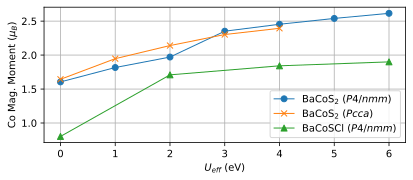

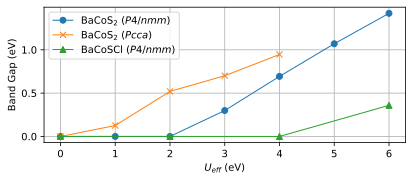

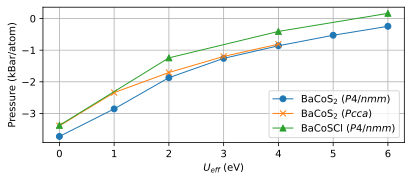

In [14]:
def plot_custom(dep_var, axis_label):
    fig = plt.figure(figsize=(6.5,2.5))
    plt.plot(dfs[0].indep_var, dfs[0][dep_var], marker='o', label='BaCoS$_2$ ($P$4/$nmm$)')
    plt.plot(dfs[1].indep_var, dfs[1][dep_var], marker='x', label='BaCoS$_2$ ($Pcca$)')
    plt.plot(dfs[2].indep_var, dfs[2][dep_var], marker='^', label='BaCoSCl ($P$4/$nmm$)')
    plt.legend(ncol=1)
    plt.xlabel('$U_{eff}$ (eV)')
    plt.ylabel(axis_label)
    plt.grid(1)
    plt.show()
    fig.savefig(f'U_phase_diagram_{dep_var}.png', bbox_inches='tight', dpi=400)
    

# plot_custom('de','$E$ - $E$($P$4$/nmm$) (meV/atom)')
plot_custom('mag_mom','Co Mag. Moment ($\mu_B$)')
plot_custom('band_gap','Band Gap (eV)')
plot_custom('pressure','Pressure (kBar/atom)')

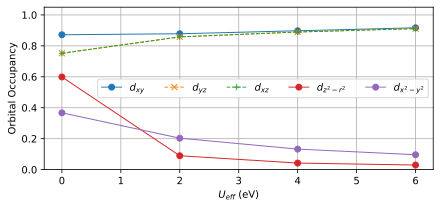

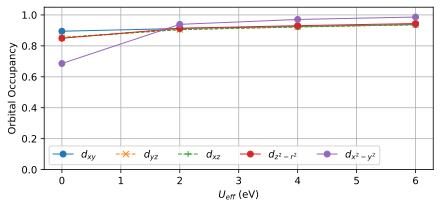

In [15]:
### Orbital Occupancies
PREFIX = home + '/Projects/storage/anion-sub_BaCoS2/BaCoSCl_PBESol_aligned_estruc'

ITERS_1 = ['P4nmm']
ITERS_2 = [0,2,4,6]

for iter1 in ITERS_1:
    ITERS = [f'{iter1}_U{iter2}' for iter2 in ITERS_2]

    df = parse_diag_occus(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=0, spin=-1)
    plot_diag_occus(f'{iter1}_dn', df, [rot_orbitals_fancy[i] for i in rot_order], norm=None)
    df = parse_diag_occus(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=0, spin=1)
    plot_diag_occus(f'{iter1}_up', df, [rot_orbitals_fancy[i] for i in rot_order], norm=None)
    #     df = parse_diag_occus(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=0, spin=-1)
#     plot_diag_occus('M1', df, [rot_orbitals_fancy[i] for i in rot_order], norm=None)
